In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

2023-01-18 12:25:31.848846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 12:25:36.154770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 12:25:36.154794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 12:25:36.592432: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-18 12:25:42.251963: W tensorflow/stream_executor/platform/de

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

model = tf.keras.models.load_model("models/cells/model40")
test_dir = "cell_images/test/"
test_dataset = image_dataset_from_directory(
                test_dir,
                labels = "inferred",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = False
                )

x = test_dataset.unbatch()
imgs = np.array(list(x.map(lambda x, y: x)))
labels = np.array(list(x.map(lambda x, y: y)))

2023-01-18 12:27:12.383392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 12:27:12.383791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 12:27:12.383898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-18 12:27:12.383982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-18 12:27:12.384060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Found 2600 files belonging to 2 classes.


In [3]:
imgs = imgs[labels == 0]
labels = labels[labels == 0]
imgs.shape


(1300, 128, 128, 3)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

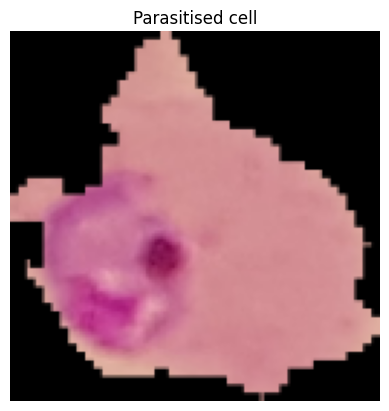

In [4]:
plt.imshow(imgs[0].astype('uint8'))
plt.axis('off')
plt.title('Parasitised cell')
labels[:10]

In [5]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros([imgs.shape[0], imgs.shape[1], imgs.shape[2]])

for img in range(imgs.shape[0]):
    heatmaps[img, :, :] = GradCam(imgs[img, :, :, :], model, pred_index=0)
    heatmaps[img, :, :] /= 255


In [58]:
from sklearn.datasets import make_blobs
from sklearn import mixture
from skimage.morphology import opening, disk, square
from tqdm import tqdm

segmentatons = np.zeros_like(heatmaps)
#region_means = np.zeros([imgs.shape[0], 4, 3])
for img in tqdm(range(imgs.shape[0])):
    v_I = np.reshape(imgs[img, :,:,:],(imgs[img, :,:,:].shape[0]*imgs[img,:,:,:].shape[1],imgs[img,:,:,:].shape[2]))
    gmm_win = mixture.GaussianMixture(n_components=5,covariance_type='full').fit(v_I)

    # mean_list = []
    # for mean in gmm_win.means_:
    #     if mean[0] >= 1e-5:
    #         mean_list.append(mean)
    # mean_list = np.array(mean_list)
    

    # region_means[img] = mean_list
    v_I_gmm = gmm_win.predict(v_I)
    I_gmm = np.reshape(v_I_gmm,[imgs[img,:,:,:].shape[0],imgs[img,:,:,:].shape[1]])
    opened = opening(I_gmm, disk(4))
    segmentatons[img,:,:] = opened

100%|██████████| 1300/1300 [05:53<00:00,  3.68it/s]


In [59]:
with open("segmentatons.npy", 'wb') as f:
    np.save(f, segmentatons)

# with open("region_means.npy", 'wb') as f:
#     np.save(f, region_means)


In [6]:
segmentatons = np.load("segmentatons.npy")

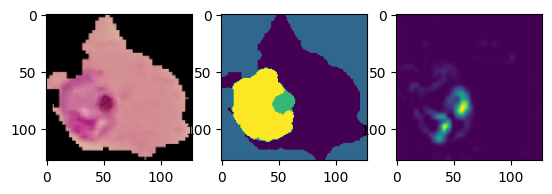

In [85]:
idx = -0
fig,ax = plt.subplots(1,3)
ax[0].imshow(imgs[idx].astype('uint8'))
ax[1].imshow(segmentatons[idx])
ax[2].imshow(heatmaps[idx])


In [7]:
from skimage.measure import regionprops_table
import plotly.express as px
t = np.copy(segmentatons[1].astype('uint8'))
y = np.copy(imgs[0].astype('uint8'))
if t[0][0] != 0:
    t[t==0] = (np.unique(t)[-1] + 1)
    t[t==t[0][0]] = 0

print(np.unique(t))

#t[t==0] = 4
props = pd.DataFrame(regionprops_table(t, properties=['area']))
print(props)
px.imshow(t)

[0 1 3]
    area
0  11146
1    289


In [8]:
#find number of blobs in all images
num_blobs_array = []
for img in range(imgs.shape[0]):
    num_blobs_array.append(np.unique(segmentatons[img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

4629

In [9]:
num_blobs/imgs.shape[0]

3.560769230769231

In [10]:
#modify all segmentation images
for idx in range(segmentatons.shape[0]):
    img = segmentatons[idx]
    if img[0][0] != 0:
        img[img==0] = (np.unique(img)[-1] + 1)
        img[img==img[0][0]] = 0

segmentatons = segmentatons.astype('uint8')

In [11]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
green_vals = np.zeros(num_blobs)
red_vals = np.zeros(num_blobs)
blue_vals = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(imgs.shape[0]):
    img_highscore = 0
    for region in np.unique(segmentatons[img]):   
        if region != 0:
            x = np.copy(segmentatons[img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = heatmaps[img] * x
            img_green_val = imgs[img, :, :, 1] * x
            img_red_val = imgs[img, :, :, 0] * x
            img_blue_val = imgs[img, :, :, 2] * x

            scores[i] = np.mean(img_score[img_score!=0])

            green_vals[i] = np.mean(img_green_val[img_green_val!=0])
            red_vals[i] = np.mean(img_red_val[img_red_val!=0])
            blue_vals[i] = np.mean(img_blue_val[img_blue_val!=0])
            if scores[i] > img_highscore:
                img_highscore = scores[i]
            i += 1
    highscores.append(img_highscore)
        

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [12]:
scores = np.nan_to_num(scores, nan=0)

In [91]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(1301,)

In [13]:
from skimage.measure import regionprops_table
from tqdm import tqdm
blob_areas = []
blob_eccentricities = []
blob_eq_diameter = []
blob_bboxs = []
blob_major_axes = []
blob_minor_axes = []
blob_extents = []
blob_solidities = []

for img in tqdm(range(imgs.shape[0])):
    areas = pd.DataFrame(regionprops_table(segmentatons[img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_diameter = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    bbox = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['area_bbox'])).to_numpy().squeeze()
    major_axis = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['axis_major_length'])).to_numpy().squeeze()
    minor_axis = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['axis_minor_length'])).to_numpy().squeeze()
    extent = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['extent'])).to_numpy().squeeze()
    solidity = pd.DataFrame(measure.regionprops_table(segmentatons[img], properties=['solidity'])).to_numpy().squeeze()
    if areas.shape == ():
        blob_areas.append(areas)
    else:
        blob_areas += areas.tolist()

    if eccentricities.shape == ():
        blob_eccentricities.append(eccentricities)
    else:
        blob_eccentricities += eccentricities.tolist()

    if eq_diameter.shape == ():
        blob_eq_diameter.append(eq_diameter)
    else:
        blob_eq_diameter += eq_diameter.tolist()

    if bbox.shape == ():
        blob_bboxs.append(bbox)
    else:
        blob_bboxs += bbox.tolist()

    if major_axis.shape == ():
        blob_major_axes.append(major_axis)
    else:
        blob_major_axes += major_axis.tolist()

    if minor_axis.shape == ():
        blob_minor_axes.append(minor_axis)
    else:
        blob_minor_axes += minor_axis.tolist()

    if extent.shape == ():
        blob_extents.append(extent)
    else:   
        blob_extents += extent.tolist()

    if solidity.shape == ():
        blob_solidities.append(solidity)
    else:
        blob_solidities += solidity.tolist()

blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_diameter = np.asarray(blob_eq_diameter)
blob_bboxs = np.asarray(blob_bboxs)
blob_major_axes = np.asarray(blob_major_axes)
blob_minor_axes = np.asarray(blob_minor_axes)
blob_extents = np.asarray(blob_extents)
blob_solidities = np.asarray(blob_solidities)
blob_areas.shape


100%|██████████| 1300/1300 [00:17<00:00, 73.39it/s]


(4629,)

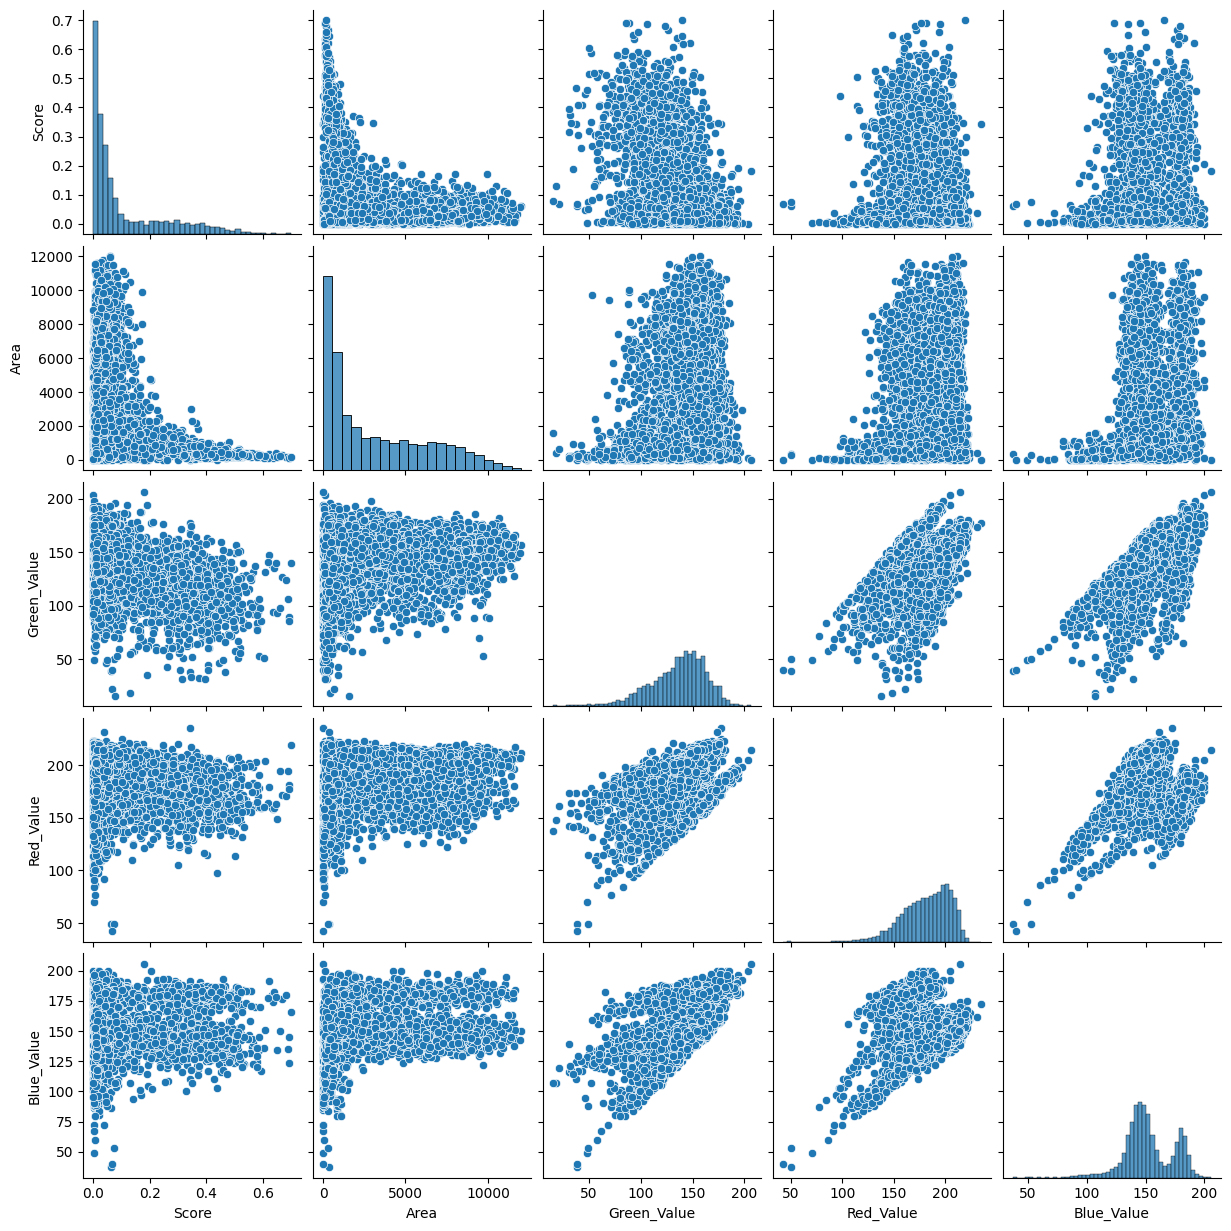

In [93]:
from seaborn import pairplot
data = pd.DataFrame({'Score': scores, 
                        'Area': blob_areas,
                        'Green_Value' : green_vals,
                        'Red_Value': red_vals,
                        'Blue_Value': blue_vals
                    })

pairplot(data)


In [21]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.vstack((green_vals, red_vals, blue_vals, blob_areas, blob_eccentricities, blob_eq_diameter, blob_bboxs, blob_extents, blob_major_axes, blob_minor_axes, blob_solidities))
X = np.vstack((green_vals, blob_major_axes))

X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [22]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=2)
regressor = regressor.fit(X_train, y_train)

In [16]:
score = regressor.score(X_test, y_test)
score

0.5174185297714565

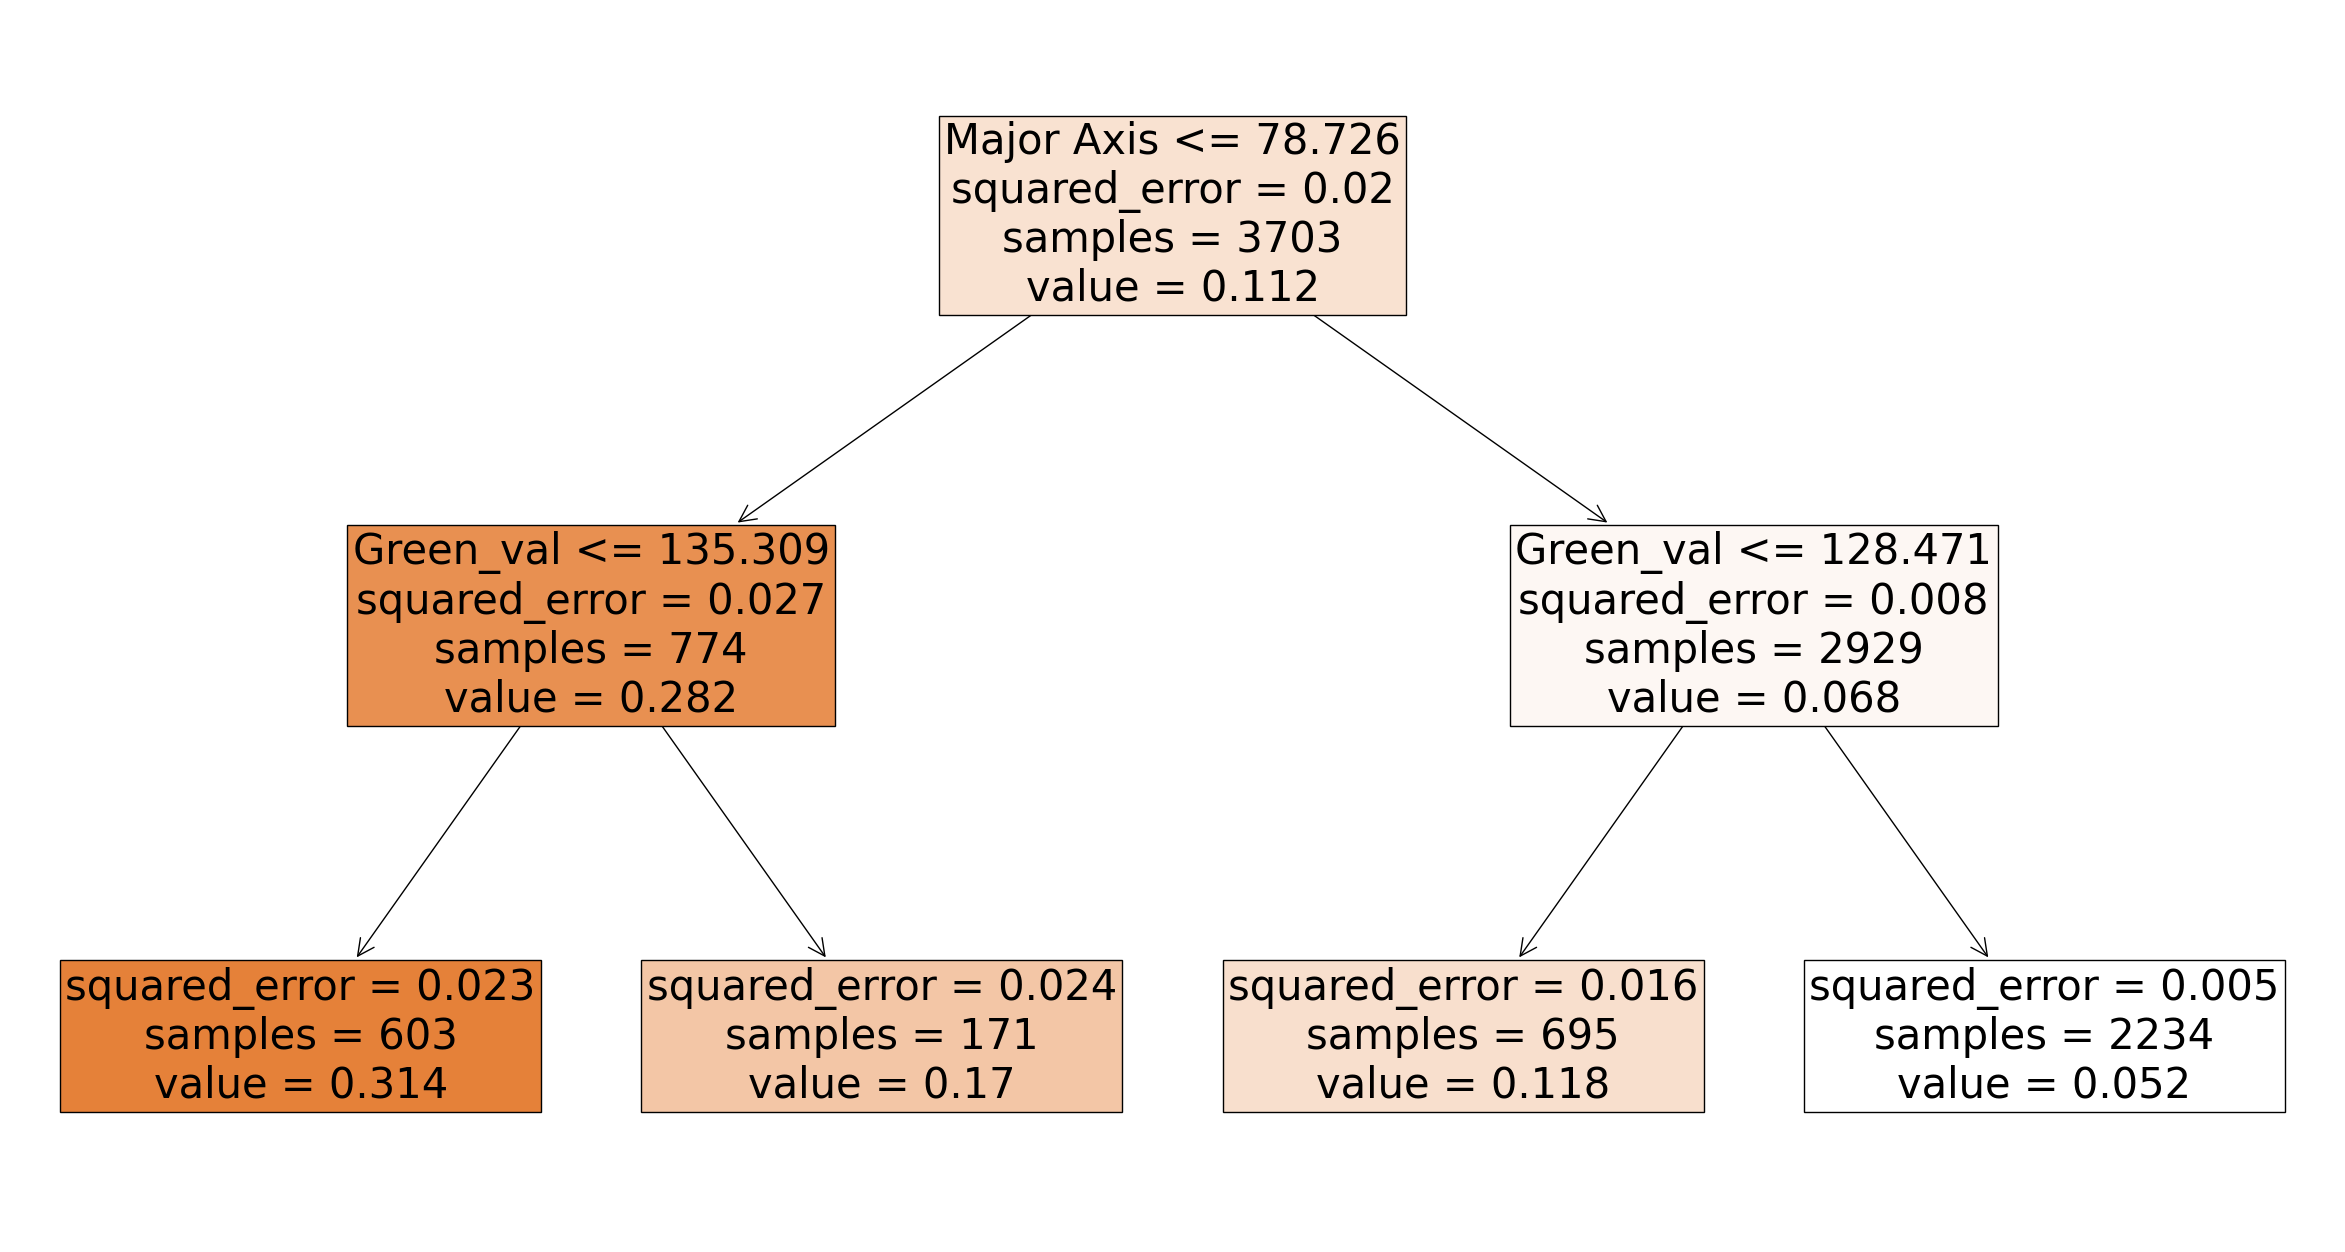

In [24]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,16))
#plot_tree(regressor, max_depth=3, feature_names=['Green_val', 'Red_val', 'Blue_val', 'Area', 'Eccentricity', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Minor Axis', 'Solidity'], filled=True, fontsize=8, precision=5)
plot_tree(regressor, max_depth=2, feature_names=['Green_val','Major Axis'], filled=True, fontsize=30, precision=3)

plt.show()


In [18]:
from sklearn.ensemble import RandomForestRegressor

feature_names = ['Green_val', 'Red_val', 'Blue_val', 'Area', 'Eccentricity', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Major Axis', 'Solidity']
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats = 10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

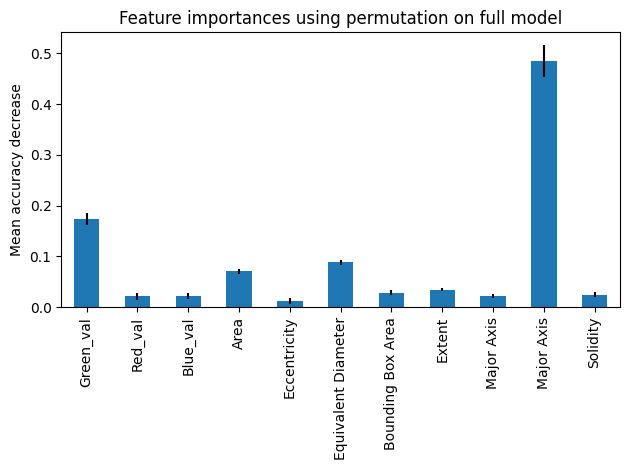

In [20]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [54]:
top3 = forest_importances.sort_values(ascending=False).head(3).index.values
print("The most important features are: " + "1: " + top3[0] + " " + "2: " + top3[1] + " " + "3: " + top3[2])

The most important features are: 1: Major Axis 2: Green_val 3: Equivalent Diameter
